In [ ]:
#!unzip "/content/drive/MyDrive/Dog images classification/dog-breed-identification.zip" -d "/content/drive/MyDrive/Dog images classification/"

This is Ashish Singh's notebook. LOL!

# End to end multiclass dog breed classification
This notebook builds an end-to-end multi-class image classifier using tensorflow2.0 and TensorFlowHub.

### 1.Problem
Identifying the breed of a dog given an image of a dog.

### 2.Data
https://www.kaggle.com/competitions/dog-breed-identification/data
 
### 3.Evaluation

Evaluation is prediction probabilities for each dog breed of each test image.
https://www.kaggle.com/competitions/dog-breed-identification/overview/evaluation

### 4.Features
Some info about the data:
* We're dealing with images/unstructured data so need to use deep learning/transfer learning.
* There are 120 dog breeds mentioned for the competition
* There are around 10,000+ images in training set(with labels)
* there are 10,000 images in test set( with no labels, since we are going to predict them)

**Getting workspace ready**::\:

In [ ]:
# Import Tensorflow into colab
import tensorflow as tf
import tensorflow_hub as hub
print("TF version:", tf.__version__)
print("TF HUB Version", hub.__version__)

TF version: 2.8.0
TF HUB Version 0.12.0


In [ ]:
# Check for GPU availablity
print("GPU", "available (YES!)" if tf.config.list_physical_devices("GPU") else "not available:(" )

GPU available (YES!)


## Getting our data ready (turning into Tensors)

turning images into tensors( numerical representation)
Let's start by accessing our data and checking out the labels.

In [ ]:
## Check the labels of our data
import pandas as pd
labels_csv = pd.read_csv("drive/MyDrive/Dog images classification/labels.csv")

In [ ]:
labels_csv.describe()

,id,breed
count,10222,10222
unique,10222,120
top,000bec180eb18c7604dcecc8fe0dba07,scottish_deerhound
freq,1,126


In [ ]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


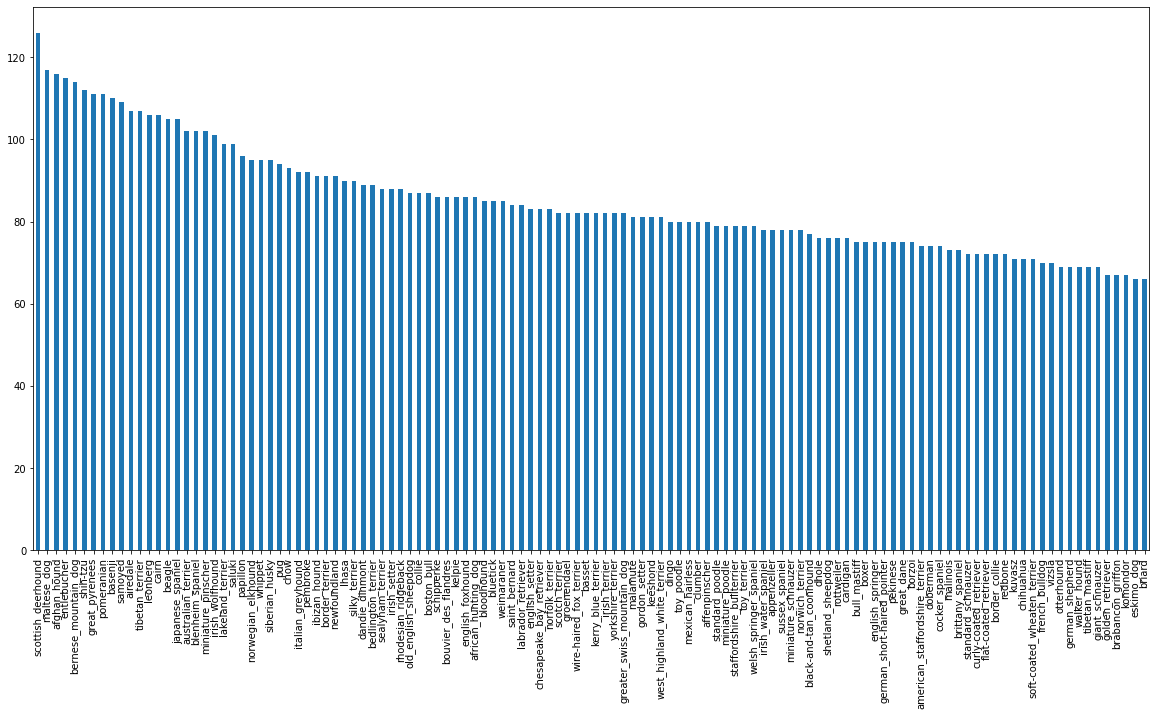

In [ ]:
# How many images are there in each breed
labels_csv.breed.value_counts().plot(kind='bar', figsize=(20,10))

In [ ]:
labels_csv.breed.value_counts().median()

82.0

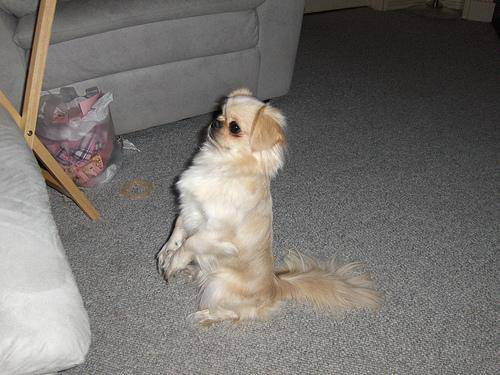

In [ ]:
# Viewing an image
from IPython.display import Image
Image('drive/MyDrive/Dog images classification/train/001cdf01b096e06d78e9e5112d419397.jpg')

### Getting images and their labels

Let's get a list of all our image file pathnames

In [ ]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [ ]:
# Create pathnames from image ID's
filenames = ["drive/MyDrive/Dog images classification/train/" + fname + ".jpg" for fname in labels_csv.id]

filenames[:10]

['drive/MyDrive/Dog images classification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Dog images classification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Dog images classification/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Dog images classification/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Dog images classification/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Dog images classification/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Dog images classification/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Dog images classification/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Dog images classification/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Dog images classification/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [ ]:
import os
os.listdir("drive/MyDrive/Dog images classification/train/")[:10]

['000bec180eb18c7604dcecc8fe0dba07.jpg',
 '001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '001cdf01b096e06d78e9e5112d419397.jpg',
 '00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '0021f9ceb3235effd7fcde7f7538ed62.jpg',
 '002211c81b498ef88e1b40b9abf84e1d.jpg',
 '00290d3e1fdd27226ba27a8ce248ce85.jpg',
 '002a283a315af96eaea0e28e7163b21b.jpg',
 '003df8b8a8b05244b1d920bb6cf451f9.jpg',
 '0042188c895a2f14ef64a918ed9c7b64.jpg']

In [ ]:
# Checking # of filenames == # of image files
import os
if len(os.listdir("drive/MyDrive/Dog images classification/train/")) == len(filenames):
  print("Filenames match actual amount of files. Please proceed.")
else:
  print("Filenames do not match actual amount of files, check the target directory")

Filenames match actual amount of files. Please proceed.


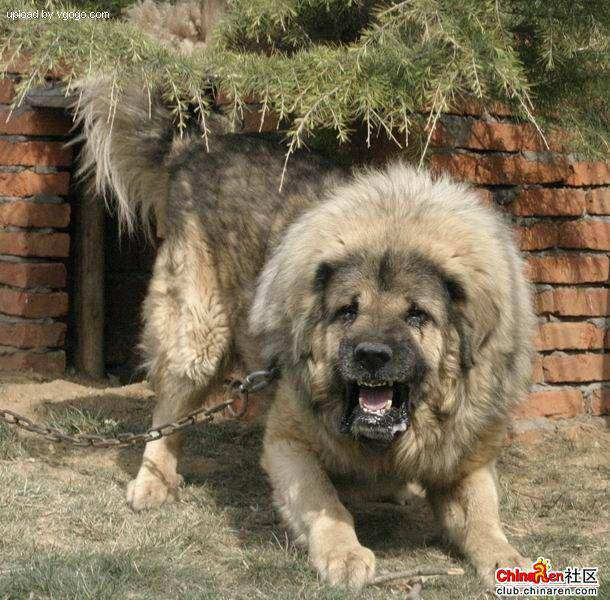

In [ ]:
Image(filenames[9000])

In [ ]:
labels_csv.loc[9000]["breed"]

'tibetan_mastiff'

Since we'hve now got our training image filepaths in a list, let's prepare our labels.

In [ ]:
import numpy as np
labels = labels_csv['breed'].to_numpy()
#labels = np.array(labels)
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [ ]:
len(labels)

10222

In [ ]:
# See if number of labels matches the number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames")
else:
  print("number of labels doesn't match number of filenames!")

Number of labels matches number of filenames


In [ ]:
# Find the unique label values
unique_breeds = np.unique(labels)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [ ]:
len(unique_breeds)

120

In [ ]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [ ]:
boolean_labels = [label==unique_breeds for label in labels]
boolean_labels

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [ ]:
len(boolean_labels)

10222

In [ ]:

# How one hot encoding works
print(labels[0])
print(np.where(unique_breeds == labels[0]))
print(boolean_labels[0].argmax())
print(boolean_labels[0].astype(int))

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


## Creating our own validation set


In [ ]:
# Setup X & y variables
X = filenames
y = boolean_labels

We're going to start off experimenting with ~1000 images and increase as needed.


In [ ]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

In [ ]:
# Splitting data
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES], y[:NUM_IMAGES], test_size=0.2, random_state=32)

In [ ]:
len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [ ]:
X_train[:2], y_train[:2]

(['drive/MyDrive/Dog images classification/train/13cab1309bdaf21aa17cf71fd6f88a65.jpg',
  'drive/MyDrive/Dog images classification/train/0b3d3120a62c2bc280f589d473041d06.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False,  True, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, F

Preprocessing Images (turning images into Tensors)

In [ ]:

# Convert image to nupmy array
from matplotlib.pyplot import imread
image = imread(filenames[32])
image.shape

(375, 500, 3)

In [ ]:
image.max(), image.min()

(255, 0)

In [ ]:
image[:3]

array([[[ 0, 18,  5],
        [ 2, 22, 10],
        [72, 92, 80],
        ...,
        [ 1, 12,  4],
        [ 3, 14,  6],
        [ 5, 16,  8]],

       [[45, 65, 53],
        [ 0,  7,  0],
        [ 0, 13,  1],
        ...,
        [ 3, 14,  6],
        [ 4, 15,  7],
        [ 6, 17,  9]],

       [[45, 65, 53],
        [17, 37, 25],
        [ 0, 14,  2],
        ...,
        [ 4, 14,  6],
        [ 5, 15,  7],
        [ 6, 16,  8]]], dtype=uint8)

In [ ]:
tf.constant(image)

<tf.Tensor: shape=(375, 500, 3), dtype=uint8, numpy=
array([[[  0,  18,   5],
        [  2,  22,  10],
        [ 72,  92,  80],
        ...,
        [  1,  12,   4],
        [  3,  14,   6],
        [  5,  16,   8]],

       [[ 45,  65,  53],
        [  0,   7,   0],
        [  0,  13,   1],
        ...,
        [  3,  14,   6],
        [  4,  15,   7],
        [  6,  17,   9]],

       [[ 45,  65,  53],
        [ 17,  37,  25],
        [  0,  14,   2],
        ...,
        [  4,  14,   6],
        [  5,  15,   7],
        [  6,  16,   8]],

       ...,

       [[ 96, 137,  71],
        [ 96, 137,  71],
        [104, 144,  81],
        ...,
        [ 25,  62,  11],
        [ 14,  51,   0],
        [  9,  46,   0]],

       [[133, 174, 108],
        [117, 158,  92],
        [127, 167, 104],
        ...,
        [ 49,  86,  35],
        [ 38,  75,  24],
        [ 20,  57,   6]],

       [[106, 147,  81],
        [ 36,  77,  11],
        [ 92, 132,  69],
        ...,
        [ 43,  80,  2

# Making function to preprocess the images
1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, 'image'
3. Turn our image , a jpg, to tensors
4. Normalize our image(convert colour channel from 0-255 to 0-1).
4. Resize the 'image' to be a shape of (224,224)
5. Return the modified 'image'

In [ ]:
# Define image size
IMG_SIZE = 224

#https://www.tensorflow.org/tutorials/load_data/images

# Create a function for preprocessing images
def process_image(image_path, IMG_SIZE=224):
  """
  Takes an image file path and tuenss the image into a Tensor
  """

  #read in an image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (red, green ,blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values  from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image tp our desired value(224,224)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

In [ ]:
tensor = tf.io.read_file(filenames[26])
tensor

<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\n\x07\x07\x08\x07\x06\n\x08\x08\x08\x0b\n\n\x0b\x0e\x18\x10\x0e\r\r\x0e\x1d\x15\x16\x11\x18#\x1f%$"\x1f"!&+7/&)4)!"0A149;>>>%.DIC<H7=>;\xff\xdb\x00C\x01\n\x0b\x0b\x0e\r\x0e\x1c\x10\x10\x1c;("(;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;\xff\xc0\x00\x11\x08\x01\xf4\x01w\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98\x99\x9a\xa2\xa3\xa4\xa5\xa6\xa7\xa8\xa9\xaa\xb2\xb3\xb4\xb5\xb6\xb7\xb8\xb9\xba\xc2\xc3\xc4\xc5\xc6\xc7\xc8\xc9\xca

In [ ]:
tensor = tf.image.decode_jpeg(tensor, channels=3)

In [ ]:
tensor = tf.image.convert_image_dtype(tensor, tf.float32)

In [ ]:
tf.math.reduce_min(tensor)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [ ]:
tf.image.resize(tensor , size = (244, 244))

<tf.Tensor: shape=(244, 244, 3), dtype=float32, numpy=
array([[[0.25008392, 0.28537804, 0.27361333],
        [0.28954518, 0.3248393 , 0.3130746 ],
        [0.30132884, 0.33662295, 0.32485825],
        ...,
        [0.42241222, 0.4733926 , 0.39496124],
        [0.45012465, 0.501105  , 0.42267367],
        [0.44677037, 0.49775076, 0.4193194 ]],

       [[0.2749224 , 0.31021652, 0.2984518 ],
        [0.30795988, 0.343254  , 0.3314893 ],
        [0.2970691 , 0.33236322, 0.3205985 ],
        ...,
        [0.42203593, 0.47301632, 0.39458492],
        [0.46020165, 0.511182  , 0.43275067],
        [0.4842991 , 0.5352795 , 0.4568481 ]],

       [[0.29441643, 0.32971054, 0.3101027 ],
        [0.274257  , 0.30955112, 0.28994328],
        [0.2803445 , 0.3156386 , 0.29603076],
        ...,
        [0.47424465, 0.525225  , 0.44679368],
        [0.48777953, 0.5387599 , 0.46032855],
        [0.47346678, 0.5244472 , 0.4460158 ]],

       ...,

       [[0.7909764 , 0.7397758 , 0.6135704 ],
        [0.85

Turning our data into batches. But why dude?
If we have 10k+ images , they wont fit in GPU's memory.
So that's why we need a batch (of 32 generally) of images at a time.

To use Tensorflow we need our data in the form of tensor tuples:
`(image, lable)`

In [ ]:
# Create a simple function to return a tuple 
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label,
  processes the image and returns a tuple of (image, label)
  """
  image = process_image(image_path)
  return image, label

In [ ]:
(process_image(X[22]), tf.constant(y[22]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.1330032 , 0.05492197, 0.08260179],
         [0.12281288, 0.04473164, 0.07286915],
         [0.10271296, 0.02463173, 0.05307436],
         ...,
         [0.5843801 , 0.2659036 , 0.23074335],
         [0.42622918, 0.17718755, 0.12505569],
         [0.24508326, 0.04996776, 0.01638262]],
 
        [[0.4086272 , 0.375257  , 0.39908588],
         [0.36725003, 0.33319327, 0.35938936],
         [0.29389817, 0.25938374, 0.28715798],
         ...,
         [0.44133398, 0.20268634, 0.185602  ],
         [0.36695412, 0.16867074, 0.15405174],
         [0.2550185 , 0.08574145, 0.07356845]],
 
        [[0.56696117, 0.58506346, 0.60115546],
         [0.5850034 , 0.6031056 , 0.6203419 ],
         [0.5720782 , 0.59018046, 0.60817957],
         ...,
         [0.13036056, 0.00890197, 0.00958708],
         [0.24564041, 0.12379038, 0.15058532],
         [0.19309051, 0.06804112, 0.1088118 ]],
 
        ...,
 
        [[0.45460117, 0.4624443 

building a function to turn all of our data (x & y) into batches!

In [ ]:
BATCH_SIZE = 32

def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts data as input with no variables.
  """
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) #only filepaths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation batches....")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), #file paths
                                               tf.constant(y)))#labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating trainig data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))

    # Shuffling pathnames and labels before mapping processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    #Turning training data into batches
    data_batch = data.batch(BATCH_SIZE)
    
  return data_batch
                                               

In [ ]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating trainig data batches...
Creating validation batches....


In [ ]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

In [ ]:
y[0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

## Visualising Data Batches

Our data is now in batches. Let's visualise them

In [ ]:
import matplotlib.pyplot as plt

#Create a function for vieing images in a data batch
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from data batch.
  """
  #Setup the figure
  plt.figure(figsize=(15, 10))
  #Loop through 25 (for displaying 25 images)
  for i in  range(25):
    # create subplots
    ax = plt.subplot(5, 5, i+1)
    #Display an image
    ax.imshow(images[i])
    # Add the image label as the title
    #plt.title(unique_breeds[labels[i].argmax()])
    ax.set(title=unique_breeds[labels[i].argmax()])
    # Turn the grid lines off
    ax.axis('off')



In [ ]:
train_images, train_labels = next(train_data.as_numpy_iterator())
train_images, train_labels

(array([[[[7.90591776e-01, 7.77387917e-01, 8.26274514e-01],
          [8.06862354e-01, 7.93480277e-01, 8.42426240e-01],
          [7.85520971e-01, 7.74544597e-01, 8.22688639e-01],
          ...,
          [7.70203769e-01, 7.74125338e-01, 7.81968474e-01],
          [7.72829294e-01, 7.76750863e-01, 7.84593999e-01],
          [7.78781652e-01, 7.82703221e-01, 7.90546358e-01]],
 
         [[7.64664173e-01, 7.17994094e-01, 7.46162832e-01],
          [7.86517024e-01, 7.39744961e-01, 7.67913818e-01],
          [7.84436822e-01, 7.39040613e-01, 7.67209470e-01],
          ...,
          [7.71042466e-01, 7.74964035e-01, 7.90650308e-01],
          [7.72993624e-01, 7.76915193e-01, 7.92601466e-01],
          [7.81162560e-01, 7.85084128e-01, 8.00770402e-01]],
 
         [[7.69083500e-01, 6.89706683e-01, 6.97900116e-01],
          [7.59910941e-01, 6.80534124e-01, 6.88744426e-01],
          [7.62731612e-01, 6.83354795e-01, 6.91337168e-01],
          ...,
          [7.81406164e-01, 7.77484596e-01, 8.0101

In [ ]:
len(train_images), len(train_labels)

(32, 32)

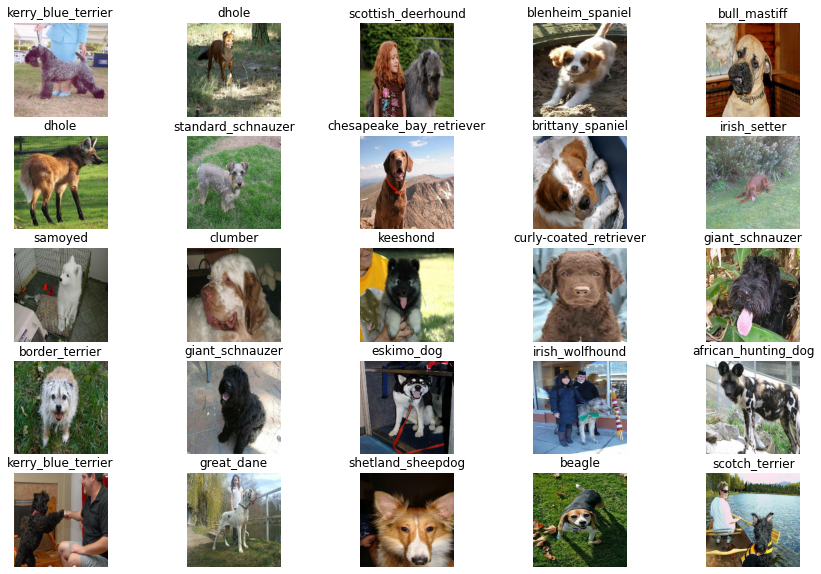

In [ ]:
# Now let's visualize the data in a training batch
show_25_images(train_images, train_labels)

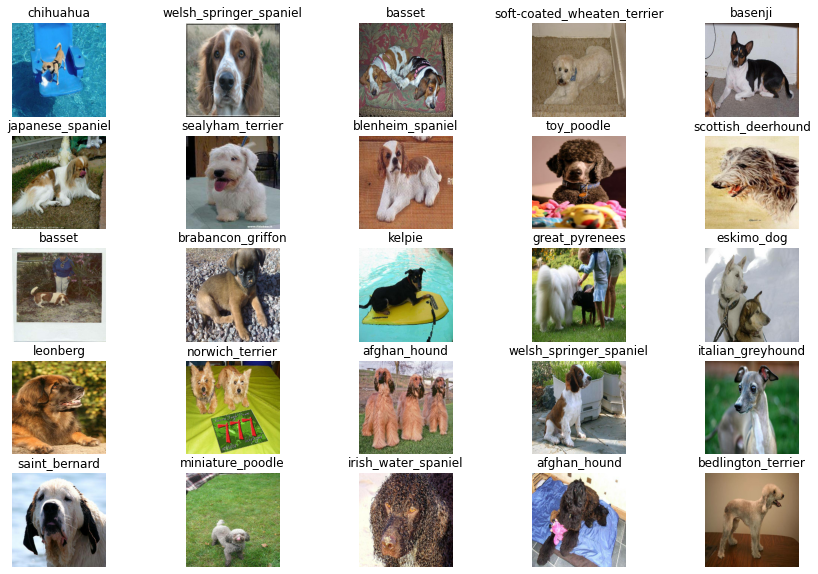

In [ ]:
#Visualise validation set
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## Building the doggo model

Before we build a model, there are a few things we need to define:
* The input shape (our images shape, in the form of Tensors) to our model.
* The output shape (image labels, in the form of Tensors) of our model.
* The URL of the model we want to use from TensorFlow Hub-
https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5

In [ ]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] #btach, height, width , color channels

# Setup the output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup the model URL from TensorFlow hub
MODEL_URL = 'https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5'

We have our inputs and outputs and model ready to go. Let's put them
together into a Keras deep learning model.

Knowing this, let's create a function which:
* Takes the input shape, output shape and the model we've  chosen as parameters.
* Defines the layers in a Keras model in sequential fashion (do this first, then this and then that).
* Compiles the model (says it should be evaluated and improved).
* Build the model (tells the model the input shape it'll be getting).
* Returns the model.

https://www.tensorflow.org/guide/keras/sequential_model

In [ ]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  # Setup the model layers

  model = tf.keras.Sequential([hub.KerasLayer(MODEL_URL), #Layer 1 (input layer)
                              tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                                                    activation='softmax') #Layer 2 (input layer)
                              
  ])
   #Compile the model
  model.compile(
     loss=tf.keras.losses.CategoricalCrossentropy(),
     optimizer=tf.keras.optimizers.Adam(),
     metrics=["accuracy"]
      )
 
  #Build the model
  model.build(INPUT_SHAPE)

  return model

In [ ]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


## Creating callbacks

Callbacks are helper functions a model can use during training to do such things as save its progress, check its progress or stop training early if a model 
stops improving.

We'll create two callbacks , one for TensorBoard which helps track our models progress and another for early stopping which prevents our model from training for too long.

## TensorBoard callbacks:

To setup a tensorboard callback we need to do 3 things:
1. Load the tensorboard notebook extension.
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's `fit()` function.
3. Visualise our models training logs with the %tensorboard magic function (we'll do this after model training).


In [ ]:
# Load Tensorboard notebook extension
%load_ext tensorboard



In [ ]:
import datetime

# Function to build a TensorBoard callback

def create_tensorboard_callback():
  # Create a log directory for storing tensorBoard logs
  logdir = os.path.join("drive/MyDrive/Dog images classification/logs ",
                        #Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
                        )
  return tf.keras.callbacks.TensorBoard(logdir)


### Early stopping callback

# Early stopping helps our model from overfitting by stoppping  training if a certain evaluation metric stops improving.


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

## Training our model (on a subset of data)

Our first model is only going to train on 1000 images, to make sure everything is working.

In [ ]:
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100,step:10}

In [ ]:
# Check to make sure we are using GPU
print("GPU, available. cool!!!" if tf.config.list_physical_devices("GPU") else "not available")

GPU, available. cool!!!


# Function which creates a model.
* Create a model using `create_model()`
* Setup a TensorBoard callback using `create_tensorboard_callback()`
* Call the `fit()` function on our model passing it the training data,        validation data, number of epochs to train for (`NUM_EPOCHS`) and callbacks we'd like to use.
* Return the model.


In [ ]:
# Build a function to train and return a trained model
def train_model():
  """ 
  Train a given model and returns the trained version.
  """
  # Create a model
  model = create_model()

  # Create new TensorBoard session everytime
  tensorboard = create_tensorboard_callback()
  
  # Fit the model to the data, passing it the callbacks we created

  model.fit(x=train_data, 
            epochs=NUM_EPOCHS,
            validation_data= val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  
  # Return the fitted model
  return model

In [ ]:
# Training the model
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Epoch 1/100
25/25 [==============================] - 19s 162ms/step - loss: 4.5893 - accuracy: 0.0938 - val_loss: 3.3310 - val_accuracy: 0.2200
Epoch 2/100
25/25 [==============================] - 6s 245ms/step - loss: 1.6205 - accuracy: 0.7050 - val_loss: 2.1336 - val_accuracy: 0.5300
Epoch 3/100
25/25 [==============================] - 6s 256ms/step - loss: 0.5516 - accuracy: 0.9375 - val_loss: 1.6852 - val_accuracy: 0.5850
Epoch 4/100
25/25 [==============================] - 6s 235ms/step - loss: 0.2408 - accuracy: 0.9937 - val_loss: 1.5035 - val_accuracy: 0.6200
Epoch 5/100
25/25 [==============================] - 6s 253ms/step - loss: 0.1390 - accuracy: 0.9987 - val_loss: 1.4243 - val_accuracy: 0.6300
Epoch 6/100
25/25 [==============================] - 5s 211ms/step - loss: 0.0953 - accuracy: 1.0000 - val_loss: 1.3864 - val_accuracy: 0.6450
Epoch 7/100
25/25 [=============================

## Function has overfit , but its a good thing.

### Checking the TensorBoard logs

The TensorBoard magic function(`%tensorboard`) will access the logs directory we created earlier and visualiseits contents.


In [ ]:
%tensorboard --logdir drive/MyDrive/Dog\ images\ classification/logs

Reusing TensorBoard on port 6006 (pid 1577), started 0:02:15 ago. (Use '!kill 1577' to kill it.)

<IPython.core.display.Javascript object>

## Making and evaluating predictions using a pre-trained model


In [ ]:
# Make predictions on the validation data:

predictions = model.predict(val_data, verbose=2)
predictions

7/7 - 10s - 10s/epoch - 1s/step


array([[1.23113248e-04, 2.17449451e-06, 2.09021699e-02, ...,
        1.10952556e-03, 6.82056561e-05, 1.46382106e-02],
       [5.39145321e-06, 4.37336072e-04, 3.57056160e-06, ...,
        1.85576810e-05, 5.83671732e-04, 4.62575808e-05],
       [1.20407685e-05, 5.92061842e-05, 2.53710587e-05, ...,
        1.00995596e-04, 1.16718889e-04, 7.49633473e-05],
       ...,
       [7.10964116e-07, 1.14477916e-06, 2.94893631e-04, ...,
        4.70520020e-01, 2.19565263e-05, 6.42099243e-04],
       [1.43093683e-04, 1.17710102e-02, 1.42164179e-03, ...,
        3.94245200e-02, 1.20064281e-02, 6.02788532e-05],
       [3.94454855e-06, 2.32163757e-06, 1.05665940e-05, ...,
        2.16612170e-05, 4.66694161e-07, 4.90044942e-04]], dtype=float32)

In [ ]:
len(predictions[0])

120

In [ ]:
predictions.shape

(200, 120)

In [ ]:
len(unique_breeds)

120

In [ ]:
np.sum(predictions[1])

1.0

In [ ]:
# Prediction
index = 71
print(predictions[index])
print(f"Max value (probability of prediction): {np.max(predictions[index])}")
print(f"Sum: {np.sum(predictions[index])}")
print(f"Max index position: {np.argmax(predictions[index])}")
print(f"Predicted label:{unique_breeds[np.argmax(predictions[index])]}")

[1.00743235e-03 1.05104271e-04 1.24373275e-03 7.19347590e-05
 4.96034685e-04 1.10461179e-03 2.74477573e-03 5.64430244e-02
 1.48378764e-04 6.72653492e-04 7.70740036e-04 2.05940288e-02
 2.22585106e-04 5.12146973e-04 3.45216715e-04 1.60100346e-04
 1.38136977e-02 6.87199179e-04 1.77529978e-03 7.86536932e-03
 7.63010830e-05 1.26705854e-04 7.25084246e-05 1.73764405e-04
 2.98156892e-03 8.67584604e-05 5.92713535e-04 4.68359254e-02
 9.70911424e-05 2.12608650e-03 4.73965978e-04 2.66971765e-04
 1.58439728e-03 6.07517183e-01 2.18179513e-04 2.51879799e-04
 2.54779501e-04 3.55309923e-04 4.29640233e-04 1.01582578e-03
 1.82580426e-02 1.08355249e-03 4.38334158e-04 1.54351001e-04
 1.99543014e-02 1.25692680e-03 5.57491658e-05 1.03368940e-04
 1.35325667e-04 3.58114572e-04 3.54875665e-04 9.31531074e-04
 5.71163371e-04 3.14498699e-04 3.07184015e-03 8.13830062e-04
 2.49852706e-03 7.77054403e-04 1.38532443e-04 4.27558087e-03
 2.22945120e-03 1.65938195e-02 5.52646816e-04 6.55821350e-04
 1.75921712e-04 2.123902

In [ ]:
unique_breeds[33]

'collie'

Having the above functionality is great but we want to be able to do it at scale.

And it would be even better if we could see the image the prediction is being made on!

**Note:** Prediction probabilities are also known as confidence levels.

In [ ]:
# Turn prediction probabilities into their respective label (Easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of predicitons into a label.
  """

  return unique_breeds[np.argmax(prediction_probabilities)]
# Get a predicted label based on an array of prediciton probabilities
pred_label = get_pred_label(predictions[0])
pred_label

'basenji'

In [ ]:
val_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

Need to unbatch our validation data first to make any predictions on validation images and then compare those predictions to the validation labels (truth labels).

In [ ]:
# Funtion to unbatch
images_=[]
labels_=[]
def unbatch_data(data):
  for image, label in data.unbatch().as_numpy_iterator():
    images_.append(image)  
    labels_.append(unique_breeds[np.argmax(label)])
  return images_, labels_  

In [ ]:
val_images, val_labels = unbatch_data(val_data)


In [ ]:
val_images[0], val_labels[0]

(array([[[0.16123949, 0.5533964 , 0.6788866 ],
         [0.1827031 , 0.57486   , 0.70035017],
         [0.196128  , 0.5882849 , 0.7137751 ],
         ...,
         [0.17362626, 0.5139023 , 0.596823  ],
         [0.12144795, 0.5194187 , 0.6078984 ],
         [0.11841376, 0.53410006, 0.62037456]],
 
        [[0.16719642, 0.56327486, 0.6809219 ],
         [0.15776013, 0.55383855, 0.6714856 ],
         [0.14778373, 0.54386216, 0.6615092 ],
         ...,
         [0.15516306, 0.49736187, 0.60306394],
         [0.16081475, 0.5631959 , 0.65406144],
         [0.09440335, 0.5100897 , 0.60420734]],
 
        [[0.1597339 , 0.55581236, 0.6734594 ],
         [0.11379905, 0.5098775 , 0.62752455],
         [0.16361757, 0.559696  , 0.6773431 ],
         ...,
         [0.21408445, 0.56579137, 0.6968751 ],
         [0.14985083, 0.5576066 , 0.6604252 ],
         [0.11968762, 0.54074854, 0.64024085]],
 
        ...,
 
        [[0.14365608, 0.52796984, 0.62600905],
         [0.1893058 , 0.58811533, 0.67890

In [ ]:
get_pred_label(val_labels[72])

'affenpinscher'

In [ ]:
get_pred_label(val_labels[72])

'affenpinscher'

Now we have got ways to get:

* Prediction labels

* Validation labels (truth labels)

* Validation images

Let's make some function to make all a bit more visualise

Create a function which:

* Takes an array of prediction probabilities, an array of truth labels and an array of images and an integer.

* Convert the predictions probabilities to a predicted label.

* Plot the predicted label, its predicted probability, the truth label and the target image on a single plot.

In [ ]:
def plot_pred(prediction_probabilities, labels, images, n=72):
  """ 
  View the prediction, ground truth and image for sample n
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)

  # Plot the image and remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  #Change the color of the title depending on if the predictions is right or wrong
  if pred_label==true_label:
    color = "green"
  
  else:
    color = "red"

  # Change plot title to be predicted, probability of prediction and truth label

  plt.title("{} {:2.0f}% {}".format(pred_label,
                                    np.max(pred_prob)*100, true_label), color=color)

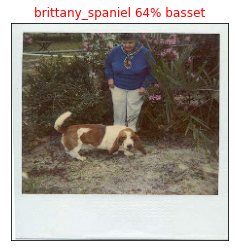

In [ ]:
plot_pred(prediction_probabilities = predictions,
                                      labels=val_labels,
                                      images=val_images, n=10)

We've got one function to visualise our models top prediction, let's make another to view our models top 10 predictions.

This function will:

* Take an input of prediction proabilities array and a ground truth array and an integer

* Find the prediction using `get_pred_label()`

* Find the top 10:

  * Prediction probabilities indexes
  * Predixtion probabilities values
  * Prediction labels

* Plot the top 10 prediction probability values and labels, coloring the true label green



In [ ]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plus the top 10 highest prediction  confidences along with the truth label for sample n.
  """

  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]

  # Find the top 10 prediciton confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]

  # Find the top 10 precition labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color = "grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels = top_10_pred_labels,
             rotation = "vertical")
  
  # Change colour of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

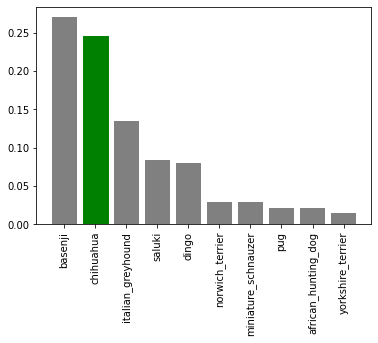

In [ ]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=0)

In [ ]:
import numpy as np  
a=np.array([456,11,63])  
a  
b=np.argsort(a)  
b  

array([1, 2, 0])

In [ ]:
predictions[0]

In [ ]:
predictions[0][predictions[0].argsort()[-10:][::-1]]

array([0.2702369 , 0.24553652, 0.13528182, 0.08364654, 0.08053658,
       0.02972498, 0.02925396, 0.02190402, 0.02090217, 0.01463821],
      dtype=float32)

In [ ]:
predictions[0].max()

0.2702369

Now we've got some function to help us visualise our preductions and evaluate our model, let's check out a few.

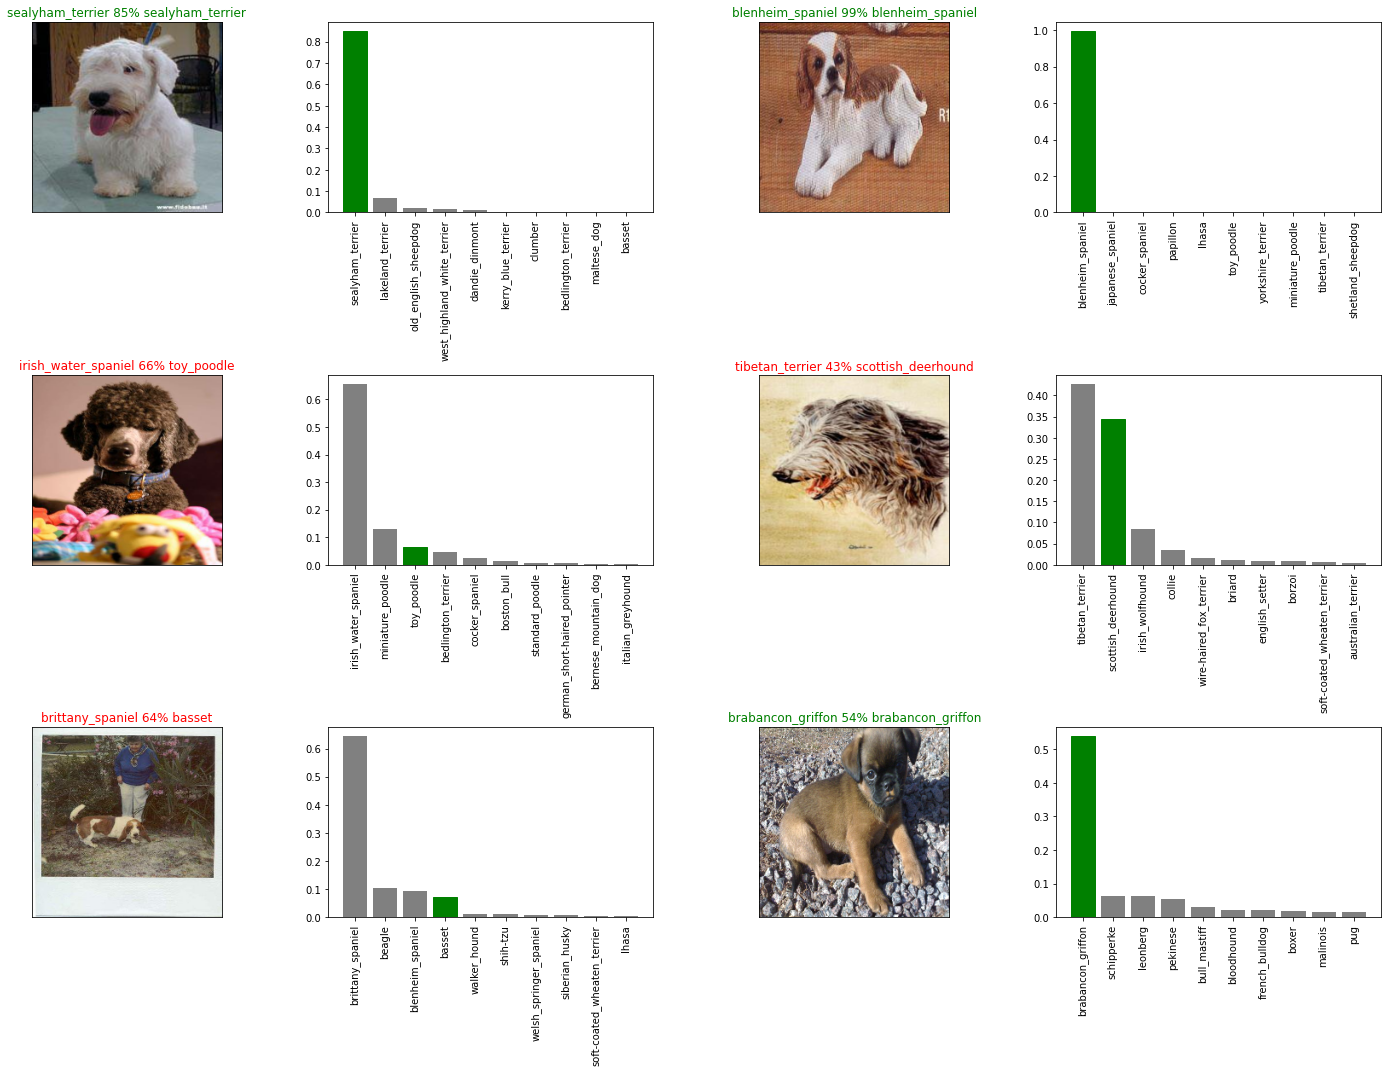

In [ ]:
# Let's checkout a few predictions and their different values
i_multiplier = 6
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))

for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
            labels=val_labels,
            n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

## Saving and reloading a training model

In [ ]:
# Creating a function to save model
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (string).
  """

  # Create a model directory pathname with current time
  modeldir = os.path.join("drive/MyDrive/Dog images classification/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" #save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [ ]:
# Function to load model
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """

  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path, custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [ ]:
# Save our model trained on 1000 images
save_model(model, suffix="1000-images-mobilenetv2-Adam")

Saving model to: drive/MyDrive/Dog images classification/models/20220516-13361652708189-1000-images-mobilenetv2-Adam.h5...


'drive/MyDrive/Dog images classification/models/20220516-13361652708189-1000-images-mobilenetv2-Adam.h5'

In [ ]:
# Load a trained model
loaded_model_on1000_images = load_model("drive/MyDrive/Dog images classification/models/20220516-13361652708189-1000-images-mobilenetv2-Adam.h5")

Loading saved model from: drive/MyDrive/Dog images classification/models/20220516-13361652708189-1000-images-mobilenetv2-Adam.h5


In [ ]:
# Evaluate the presaved model
model.evaluate(val_data)

7/7 [==============================] - 1s 113ms/step - loss: 1.2568 - accuracy: 0.6650


[1.2567709684371948, 0.6650000214576721]

In [ ]:
loaded_model_on1000_images.evaluate(val_data)

7/7 [==============================] - 2s 114ms/step - loss: 1.2568 - accuracy: 0.6650


[1.2567709684371948, 0.6650000214576721]

## Training a biggie model on full data

In [ ]:
len(X), len(y)

(10222, 10222)

In [ ]:
# Create a data batch with full dataset
full_data = create_data_batches(X, y)

Creating trainig data batches...


In [ ]:
full_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [ ]:
#Create a model for full data
full_model = create_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5


In [ ]:
# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()
#No validation set when training on all the data, so we can't monitor validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy", 
                                                            patience=3)

**Note:** Below cell is going to take a good amount of time for first epoch because GPU has to load all the images into its memory.

In [ ]:
# Fit the full model to the full data
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard, full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 41s 117ms/step - loss: 1.3337 - accuracy: 0.6710
Epoch 2/100
320/320 [==============================] - 39s 121ms/step - loss: 0.3989 - accuracy: 0.8814
Epoch 3/100
320/320 [==============================] - 38s 119ms/step - loss: 0.2360 - accuracy: 0.9357
Epoch 4/100
320/320 [==============================] - 40s 125ms/step - loss: 0.1534 - accuracy: 0.9637
Epoch 5/100
320/320 [==============================] - 43s 134ms/step - loss: 0.1068 - accuracy: 0.9767
Epoch 6/100
320/320 [==============================] - 42s 131ms/step - loss: 0.0751 - accuracy: 0.9880
Epoch 7/100
320/320 [==============================] - 42s 132ms/step - loss: 0.0578 - accuracy: 0.9924
Epoch 8/100
320/320 [==============================] - 43s 134ms/step - loss: 0.0480 - accuracy: 0.9940
Epoch 9/100
320/320 [==============================] - 42s 132ms/step - loss: 0.0369 - accuracy: 0.9960
Epoch 10/100
320/320 [==============================] - 42s 132m

In [ ]:
#save_model(full_model, suffix="full-image-set-imagenetv2-Adam")

Saving model to: drive/MyDrive/Dog images classification/models/20220516-14371652711872-full-image-set-imagenetv2-Adam.h5...


'drive/MyDrive/Dog images classification/models/20220516-14371652711872-full-image-set-imagenetv2-Adam.h5'

In [ ]:
loaded_full_model = load_model("drive/MyDrive/Dog images classification/models/20220516-14371652711872-full-image-set-imagenetv2-Adam.h5")

Loading saved model from: drive/MyDrive/Dog images classification/models/20220516-14371652711872-full-image-set-imagenetv2-Adam.h5


## Making predictions on the tests dataset

Since our model has been trained on images in the form of Tensor batches, to make predictions on the test data, we'll have to getit into the same format.

To make predictions on test data we need to:
* Get the test image filenames
* Convert the filenames into test data batches using `create_data-batches` and setting the `test_data` parameter to `True` (since test data doesn't have labels.
* Make a predictions array by passing the test batches to the `predict()` method called on our model.


In [ ]:
# Load test image filenames
test_path = "drive/MyDrive/Dog images classification/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['drive/MyDrive/Dog images classification/test/000621fb3cbb32d8935728e48679680e.jpg',
 'drive/MyDrive/Dog images classification/test/00102ee9d8eb90812350685311fe5890.jpg',
 'drive/MyDrive/Dog images classification/test/0012a730dfa437f5f3613fb75efcd4ce.jpg',
 'drive/MyDrive/Dog images classification/test/001510bc8570bbeee98c8d80c8a95ec1.jpg',
 'drive/MyDrive/Dog images classification/test/001a5f3114548acdefa3d4da05474c2e.jpg',
 'drive/MyDrive/Dog images classification/test/00225dcd3e4d2410dd53239f95c0352f.jpg',
 'drive/MyDrive/Dog images classification/test/002c2a3117c2193b4d26400ce431eebd.jpg',
 'drive/MyDrive/Dog images classification/test/002c58d413a521ae8d1a5daeb35fc803.jpg',
 'drive/MyDrive/Dog images classification/test/002f80396f1e3db687c5932d7978b196.jpg',
 'drive/MyDrive/Dog images classification/test/0036c6bcec6031be9e62a257b1c3c442.jpg']

In [ ]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches...


In [ ]:
test_data

<BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

Calling predict on our full model and passing it test batch is going to take a long time.


In [ ]:
# Make preductions on test data batch using the loaded full model
test_predictions = loaded_full_model.predict(test_data, verbose=2)

324/324 - 37s - 37s/epoch - 116ms/step


In [ ]:
# Save predictions (NumPy array) to csv file(for access later)
#np.savetxt("drive/MyDrive/Dog images classification/preds_array.csv", test_predictions, delimiter=',')

In [ ]:
# Load predictions (NumpPy array) from csv file
test_predictions = np.loadtxt("drive/MyDrive/Dog images classification/preds_array.csv", delimiter=",")

In [ ]:
test_predictions[:10]

array([[2.24745014e-11, 6.46864550e-12, 1.98981389e-14, ...,
        9.70411428e-14, 6.76224010e-09, 9.29291991e-11],
       [5.38224504e-06, 2.54508041e-06, 3.69254316e-08, ...,
        1.27630163e-11, 4.41259047e-08, 6.13981477e-10],
       [1.15079639e-11, 7.14046166e-07, 6.22411989e-09, ...,
        8.34435298e-07, 1.87719874e-11, 1.53989772e-11],
       ...,
       [3.66446162e-09, 6.24849894e-11, 1.75549256e-10, ...,
        2.45303040e-12, 1.12102667e-12, 1.09837217e-11],
       [2.09928498e-11, 1.53909330e-10, 8.57147756e-11, ...,
        1.21822120e-06, 1.39737164e-08, 1.68105772e-11],
       [2.72703171e-09, 4.34425022e-12, 2.05994614e-11, ...,
        1.76258883e-13, 4.80530025e-12, 2.82882660e-08]])

In [ ]:
test_predictions.shape

(10357, 120)

## Preparing test dataset predictions for submission to kaggle competition
Kaggle wants test predcitions in a csv file with id and dog breeds as column names:

https://www.kaggle.com/competitions/dog-breed-identification/overview/evaluation

In [ ]:
list(unique_breeds)

In [ ]:
# Create a dataframe with empty columns
preds_df = pd.DataFrame(columns=["id"] + list(unique_breeds))
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier


In [ ]:
# Append test image ID's to preds_df dataframe
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df["id"] = test_ids

In [ ]:
os.path.splitext(test_filenames[0])

('drive/MyDrive/Dog images classification/test/000621fb3cbb32d8935728e48679680e',
 '.jpg')

In [ ]:
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00102ee9d8eb90812350685311fe5890,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0012a730dfa437f5f3613fb75efcd4ce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,001510bc8570bbeee98c8d80c8a95ec1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,001a5f3114548acdefa3d4da05474c2e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Add the prediction probabilities to each dog breed column
preds_df[list(unique_breeds)] = test_predictions

In [ ]:
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,2.247450e-11,6.468645e-12,1.989814e-14,2.534785e-13,5.067292e-13,1.240606e-11,1.448916e-16,3.567646e-13,1.306781e-13,...,2.028655e-12,1.023576e-13,5.129965e-14,2.672927e-15,2.516998e-13,2.465370e-13,8.417380e-13,9.704114e-14,6.762240e-09,9.292920e-11
1,00102ee9d8eb90812350685311fe5890,5.382245e-06,2.545080e-06,3.692543e-08,2.860612e-09,9.352235e-07,1.373438e-08,8.488105e-07,3.128000e-07,1.548194e-08,...,1.222377e-08,1.424022e-06,6.209846e-09,1.762184e-06,6.180262e-08,1.760924e-07,4.274352e-04,1.276302e-11,4.412590e-08,6.139815e-10
2,0012a730dfa437f5f3613fb75efcd4ce,1.150796e-11,7.140462e-07,6.224120e-09,1.064352e-10,5.329242e-11,1.491264e-08,1.767793e-11,5.726848e-12,4.704310e-09,...,2.087462e-12,2.789852e-11,1.290050e-07,3.861447e-07,7.195102e-08,3.900689e-08,5.495934e-12,8.344353e-07,1.877199e-11,1.539898e-11
3,001510bc8570bbeee98c8d80c8a95ec1,2.806264e-06,9.606484e-08,1.765374e-07,1.898084e-06,1.121558e-05,3.819714e-07,5.766199e-11,2.069175e-09,8.278159e-09,...,5.082247e-07,5.629231e-11,3.549208e-07,7.140870e-11,1.987022e-07,7.813987e-10,1.091736e-16,1.360855e-02,1.076425e-11,2.725572e-08
4,001a5f3114548acdefa3d4da05474c2e,4.013124e-05,1.175522e-05,2.002092e-09,1.149601e-10,2.732810e-10,2.560945e-12,3.153506e-10,3.356917e-09,3.787401e-09,...,7.963202e-08,5.158048e-12,1.040610e-11,3.033807e-11,2.039212e-10,1.996360e-10,1.909315e-11,3.051087e-08,2.151719e-10,1.246485e-08


In [ ]:
# Saving preds_df to csv for submission to kaggle
preds_df.to_csv("drive/MyDrive/Dog images classification/test_preds.csv", index=False)

## Making predictions on custom images (Favourite part bow bow!!!)

To make predicitons on custom images, we'll:
* Get the filepaths of our own images.
* Turn the filepaths into data batches using
`create_data_batches()`. And since our custom images won't have labels we set the `test_data` parameter to `True`.
* Pass the custom image data batch to our model's `predict()` method.
* Convert the prediction output probabilities to prediciton labels.
* Compare the predicted labels to the custom images.

In [ ]:
# Get custom image filepaths
custom_path = "drive/MyDrive/Dog images classification/Murphy/"
custom_image_path = [custom_path + fname for fname in os.listdir(custom_path)]

In [ ]:
custom_image_path

['drive/MyDrive/Dog images classification/Murphy/IMG_20210116_141329-min.jpg',
 'drive/MyDrive/Dog images classification/Murphy/IMG_20210116_141329.jpg']

In [ ]:
# Turn custom images into batch datasets
custom_data = create_data_batches(custom_image_path, test_data=True)
custom_data

Creating test data batches...


<BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [ ]:
# Make predictions on our doggos images
custom_preds = loaded_full_model.predict(custom_data, verbose=2)

1/1 - 1s - 852ms/epoch - 852ms/step


In [ ]:
custom_preds.shape

(2, 120)

In [ ]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['german_shepherd', 'german_shepherd']

In [ ]:
custom_images = []
# Loop through unbatched data
for  image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

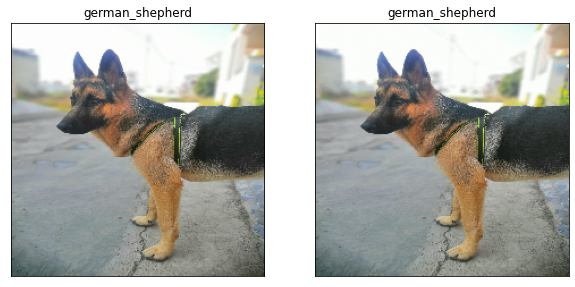

In [ ]:
# Check custom image predictions
plt.figure(figsize=(10, 10))
for i, image in enumerate(custom_images):
  plt.subplot(1, 2, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)